In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import random

def set_random_seed(seed_value=42):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using CUDA
    np.random.seed(seed_value)
    random.seed(seed_value)

# Call the function before creating your Lightning module, data module, or initializing your data loaders
set_random_seed()

# define NN 

In [18]:
class SimpleNN(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, lr=0.01):#, data_name=None, model_name=None):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        self.lr = lr
        #self.logger = pl.loggers.TensorBoardLogger("logs/", name=data_name, version=model_name) #does it need to be self.logger?

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y).sum().item() / y.size(0)
        self.log('train_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        val_loss = nn.CrossEntropyLoss()(outputs, y)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)  # Log validation loss
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y).sum().item() / y.size(0)
        self.log('val_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return val_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

# data: props_exp_scvi_tsubtypes_0.25vs0.1c_dirstr30_1000pts

In [4]:
h5ad_loc="/data/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.25vs0.1c_dirstr30_1000pts.h5ad"

In [5]:
# read in data from cache
adata = sc.read_h5ad(h5ad_loc)

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata

AnnData object with n_obs × n_vars = 445575 × 23776
    obs: 'orig_cellbarcode', 'patient_orig', 'celltype', 'Tcellsubtype', 'group', 'patient'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'group_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'

## check if by usual stats tests there is a diff between groups for each cell type proportion

In [7]:
ct_counts = adata.obs.groupby(["patient","celltype"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'celltypecounts'}).reset_index().set_index("patient")

In [8]:
person_counts = adata.obs.groupby(["patient"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'person_counts'})

In [9]:
toplot = ct_counts.merge(person_counts, right_index=True, left_index=True).merge(adata.obs[['patient','group']], left_index=True, right_on="patient")

In [10]:
toplot['celltypefracs'] = toplot['celltypecounts']/toplot['person_counts']

In [11]:
toplot = toplot[["celltype", "patient", "group", "celltypefracs"]].drop_duplicates()
toplot

,celltype,patient,group,celltypefracs
0,B-cells,sim_pt1,group1,0.334052
0,CD14+ Monocytes,sim_pt1,group1,0.185345
0,CD4 Cytotoxic,sim_pt1,group1,0.047414
0,CD8 Cytotoxic,sim_pt1,group1,0.256466
0,Helper 1,sim_pt1,group1,0.118534
...,...,...,...,...
0,CD14+ Monocytes,sim_pt1000,group2,0.119266
0,CD4 Cytotoxic,sim_pt1000,group2,0.213303
0,CD8 Cytotoxic,sim_pt1000,group2,0.119266
0,Helper 1,sim_pt1000,group2,0.174312


[Text(0, 0, 'B-cells'),
 Text(1, 0, 'CD14+ Monocytes'),
 Text(2, 0, 'CD4 Cytotoxic'),
 Text(3, 0, 'CD8 Cytotoxic'),
 Text(4, 0, 'Helper 1'),
 Text(5, 0, 'Memory Cytotoxic')]

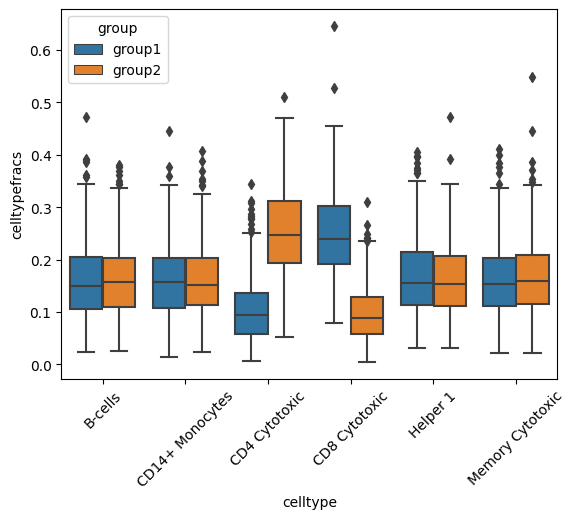

In [12]:
ax = sns.boxplot(data=toplot, x="celltype", y="celltypefracs", hue="group")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


## pseudobulk baseline, can we predict the two groups?

In [63]:
adata.obsm['X_pca'].shape

(445575, 50)

In [39]:
# pseudobulk of these sample
pseudobulk_counts = pd.DataFrame(adata.layers['counts'], index=adata.obs.patient, columns=adata.var.index).reset_index().groupby("patient").sum()
pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1))*1000000)

In [60]:
pseudobulk_lognorm

patient,sim_pt1,sim_pt2,sim_pt3,sim_pt4,sim_pt5,sim_pt6,sim_pt7,sim_pt8,sim_pt9,sim_pt10,...,sim_pt991,sim_pt992,sim_pt993,sim_pt994,sim_pt995,sim_pt996,sim_pt997,sim_pt998,sim_pt999,sim_pt1000
RP11-34P13.7,0.712814,0.729013,0.773954,0.707667,0.000000,1.217093,0.740953,0.763347,0.727600,0.000000,...,1.155031,0.745567,0.000000,0.736535,0.727632,0.724671,0.000000,0.742566,1.181919,0.000000
RP11-34P13.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FO538757.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.721043,0.000000,0.000000,0.000000
FO538757.2,3.534304,3.469416,3.616793,3.940287,3.605657,3.462782,3.422444,3.821493,3.361166,3.291488,...,3.546707,3.763296,3.671980,3.449454,3.803928,3.774188,3.519095,3.494636,3.485807,3.396995
AP006222.2,2.231925,2.549709,2.336656,2.799644,1.496288,2.095815,2.387055,2.318809,2.138977,2.228132,...,2.378021,2.491251,2.438300,2.563066,2.004319,1.843761,2.535468,2.486006,2.413483,0.767776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,1.124750,0.729013,0.000000,0.000000,0.000000,1.217093,0.000000,0.000000,1.144291,0.710650,...,0.735757,1.463929,0.770805,0.000000,0.000000,0.000000,0.721043,0.742566,0.756269,0.767776
AC004556.1,2.927202,2.549709,2.443642,2.591593,2.433197,2.232242,3.033163,2.425599,2.627656,2.805159,...,2.969390,2.034159,2.913578,2.475433,2.547248,2.891751,2.127760,3.036095,2.678536,2.433149
AC233755.2,0.000000,0.000000,0.000000,0.000000,0.000000,1.217093,0.000000,0.000000,0.000000,0.710650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.742566,0.000000,0.000000
AC233755.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### pseuodbulk: input top 3000 genes

In [163]:
### create dataloader

# take 3000 genes with highest variance
input_size = 3000
genes_to_use = pseudobulk_lognorm.var(axis=1).sort_values(ascending=False)[:input_size].index
pseudobulk_input = pseudobulk_lognorm.loc[genes_to_use,:].T

#define targets
labels, targets = np.unique(adata.obs[['patient','group']].drop_duplicates().group, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [164]:
### train model

# Example input and target tensors (replace these with your own data)
hidden_size = 128
output_size = 2  # Binary classification, so output size is 2

# Initialize the Lightning model
model = SimpleNN(input_size, hidden_size, output_size)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=100, log_every_n_steps=22, gpus=1)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 384 K 
1 | relu    | ReLU    | 0   

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [165]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.9204), 'train_acc': tensor(0.3929), 'val_loss': tensor(0.7933), 'val_acc': tensor(0.5200)}


### pseuodbulk: input top 1000 genes

In [177]:
### create dataloader

# highest variance genes
input_size = 1000
genes_to_use = pseudobulk_lognorm.var(axis=1).sort_values(ascending=False)[:input_size].index
pseudobulk_input = pseudobulk_lognorm.loc[genes_to_use,:].T

#define targets
labels, targets = np.unique(adata.obs[['patient','group']].drop_duplicates().group, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [178]:
### train model

# Example input and target tensors (replace these with your own data)
hidden_size = 128
output_size = 2  # Binary classification, so output size is 2

# Initialize the Lightning model
model = SimpleNN(input_size, hidden_size, output_size)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=100, log_every_n_steps=22, gpus=1)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 128 K 
1 | relu    | ReLU    | 0   

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [179]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.8490), 'train_acc': tensor(0.4643), 'val_loss': tensor(0.8333), 'val_acc': tensor(0.4800)}


## input mean PCs

In [174]:
### create dataloader

input_size = 50
pseudobulk_input = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.patient).reset_index().groupby("patient").mean()

#define targets
labels, targets = np.unique(adata.obs[['patient','group']].drop_duplicates().group, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [175]:
### train model

# Example input and target tensors (replace these with your own data)
hidden_size = 30
output_size = 2  # Binary classification, so output size is 2

# Initialize the Lightning model
model = SimpleNN(input_size, hidden_size, output_size)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=100, log_every_n_steps=22, gpus=1)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 1.5 K 
1 | relu    | ReLU    | 0   

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [176]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.4205), 'train_acc': tensor(0.8929), 'val_loss': tensor(0.4294), 'val_acc': tensor(0.8800)}


# data: props_exp_scvi_tsubtypes_0.1vs0.05c_dirstr30_1000pts

In [5]:
h5ad_loc="/data/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.1vs0.05_dirstr30_1000pts.h5ad"

In [6]:
# read in data from cache
adata = sc.read_h5ad(h5ad_loc)

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## check if by usual stats tests there is a diff between groups for each cell type proportion

In [16]:
ct_counts = adata.obs.groupby(["patient","celltype"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'celltypecounts'}).reset_index().set_index("patient")

In [17]:
person_counts = adata.obs.groupby(["patient"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'person_counts'})

In [18]:
toplot = ct_counts.merge(person_counts, right_index=True, left_index=True).merge(adata.obs[['patient','group']], left_index=True, right_on="patient")

In [19]:
toplot['celltypefracs'] = toplot['celltypecounts']/toplot['person_counts']

In [20]:
toplot = toplot[["celltype", "patient", "group", "celltypefracs"]].drop_duplicates()
toplot

,celltype,patient,group,celltypefracs
0,B-cells,sim_pt1,group1,0.390086
0,CD14+ Monocytes,sim_pt1,group1,0.286638
0,CD4 Cytotoxic,sim_pt1,group1,0.047414
0,CD8 Cytotoxic,sim_pt1,group1,0.028017
0,Helper 1,sim_pt1,group1,0.140086
...,...,...,...,...
0,CD14+ Monocytes,sim_pt1000,group2,0.220183
0,CD4 Cytotoxic,sim_pt1000,group2,0.084862
0,CD8 Cytotoxic,sim_pt1000,group2,0.087156
0,Helper 1,sim_pt1000,group2,0.155963


[Text(0, 0, 'B-cells'),
 Text(1, 0, 'CD14+ Monocytes'),
 Text(2, 0, 'CD4 Cytotoxic'),
 Text(3, 0, 'CD8 Cytotoxic'),
 Text(4, 0, 'Helper 1'),
 Text(5, 0, 'Memory Cytotoxic')]

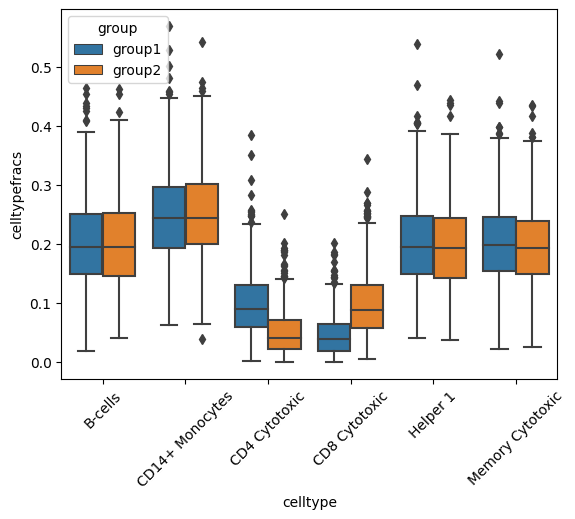

In [21]:
ax = sns.boxplot(data=toplot, x="celltype", y="celltypefracs", hue="group")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


## run baseline models using mean PCs as input

In [28]:
### create dataloader

input_size = 50
pseudobulk_input = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.patient).reset_index().groupby("patient").mean()

#define targets
labels, targets = np.unique(adata.obs[['patient','group']].drop_duplicates().group, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### Neural Network

In [33]:
### train model

# Example input and target tensors
hidden_size = 30
output_size = 2  # Binary classification, so output size is 2

# Initialize the Lightning model
lr = 0.0001
logger = pl.loggers.TensorBoardLogger('logs/', name="props_exp_scvi_tsubtypes_0.1vs0.05c_dirstr30_1000pts__50pcs_mean_lr{}_bs64".format(lr), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN(input_size, hidden_size, output_size, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=200, logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

# TO DO: Figure out how to save the model from the best epoch
# TO DO: tensorboard is saving epoch level info with steps on the x-axis. how to change to epochs on x axis?

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 1.5 K 
1 | relu    | ReLU    | 0     
2 | fc2     | Linear  | 62    
3 | softmax | Softmax | 0     
------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 93.21it/s, v_num=1433, train_loss_step=0.710, train_acc_step=0.383]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.44it/s]
Epoch 1: 100%|█| 11/11 [00:00<00:00, 81.00it/s, v_num=1433, train_loss_step=0.675, train_acc_step=0.600, val_loss_step=0.717, val_acc_step=0.364, val_loss_epoch=0.694, val_acc_epoch=0.520, tr
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.35it/s]
Epoch 2: 100%|█| 11/11 [00:00<00:00, 90.28it/s, v_num=1433, train_loss_step=0.681, train_acc_step=0.533, val_loss_step=0.718, val_acc_step=0.409, val_loss_epoch=0.694, va

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|█| 11/11 [00:00<00:00, 26.68it/s, v_num=1433, train_loss_step=0.490, train_acc_step=0.783, val_loss_step=0.645, val_acc_step=0.682, val_loss_epoch=0.592, val_acc_epoch=0.673, 


In [36]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.5141), 'train_loss_step': tensor(0.4901), 'train_acc': tensor(0.7600), 'train_acc_step': tensor(0.7833), 'val_loss': tensor(0.5915), 'val_loss_epoch': tensor(0.5915), 'val_acc': tensor(0.6733), 'val_acc_epoch': tensor(0.6733), 'train_loss_epoch': tensor(0.5141), 'train_acc_epoch': tensor(0.7600)}


### majority class

In [43]:
pd.Series(targets[train_data.indices]).value_counts()/len(train_data)

0    0.51
1    0.49
dtype: float64

In [44]:
pd.Series(targets[val_data.indices]).value_counts()/len(val_data)

1    0.52
0    0.48
dtype: float64

In [45]:
pd.Series(targets[test_data.indices]).value_counts()/len(test_data)

1    0.526667
0    0.473333
dtype: float64

### KNN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


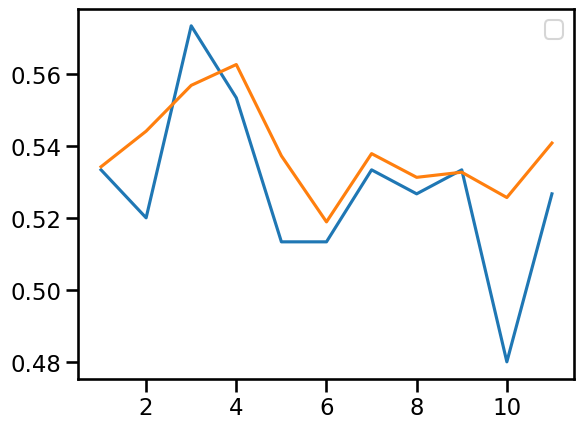

In [48]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)
plt.plot(Ks, val_aucs)
plt.legend()

In [49]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best K =  3
val acc:  0.5733333333333334
val AUC:  0.5568019943019943
test acc:  0.5066666666666667
test AUC:  0.588785879835978


### logistic regression 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


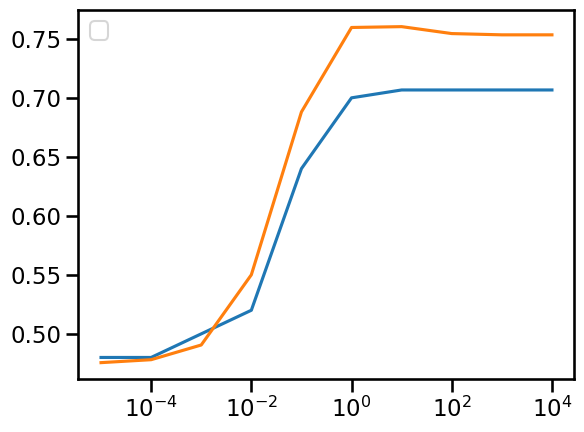

In [50]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.legend()
plt.xscale("log")

In [51]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])

neigh = LogisticRegression(C=c)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best C =  10
val acc:  0.7066666666666667
val AUC  0.7603276353276354
test acc:  0.5266666666666666
test AUC:  0.8479229809235158


### random forest

In [56]:
val_accs = []
val_aucs = []
Cs = [1,5,10,15,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)

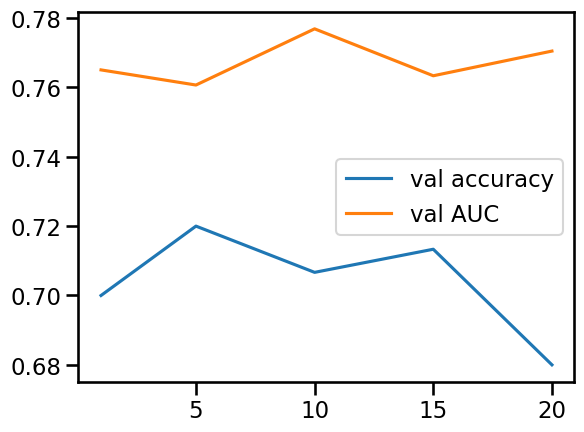

In [57]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [58]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best C =  5
test acc:  0.72
test AUC  0.7606837606837606
test acc:  0.5133333333333333
test AUC:  0.8281333571046532


## run baseline models using scGPT embeddings as input

### embed cells using scGPT

In [7]:
import scgpt as scg
import sys
from pathlib import Path

In [8]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [9]:
# scGPT code assumes counts are stored in X, so move things around accordingly
adata.X = adata.layers['counts']

In [10]:
adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col="index",
    cell_type_key="celltype",
    #obs_to_save=adata.obs.columns,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 21507/23776 genes in vocabulary of size 60697.


Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6963/6963 [08:03<00:00, 14.39it/s]
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
#save this new adata
adata.write("/data/rna_rep_learning/luca_salcher2022/props_exp_scvi_tsubtypes_0.1vs0.05_dirstr30_1000pts_w_scGPT_embeds.h5ad")

In [7]:
adata = sc.read_h5ad("/data/rna_rep_learning/luca_salcher2022/props_exp_scvi_tsubtypes_0.1vs0.05_dirstr30_1000pts_w_scGPT_embeds.h5ad")

#### Check that these scGPT embeddings look reasonable

In [12]:
sc.pp.neighbors(adata, use_rep="X_scGPT")

In [ ]:
sc.tl.umap(adata)

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


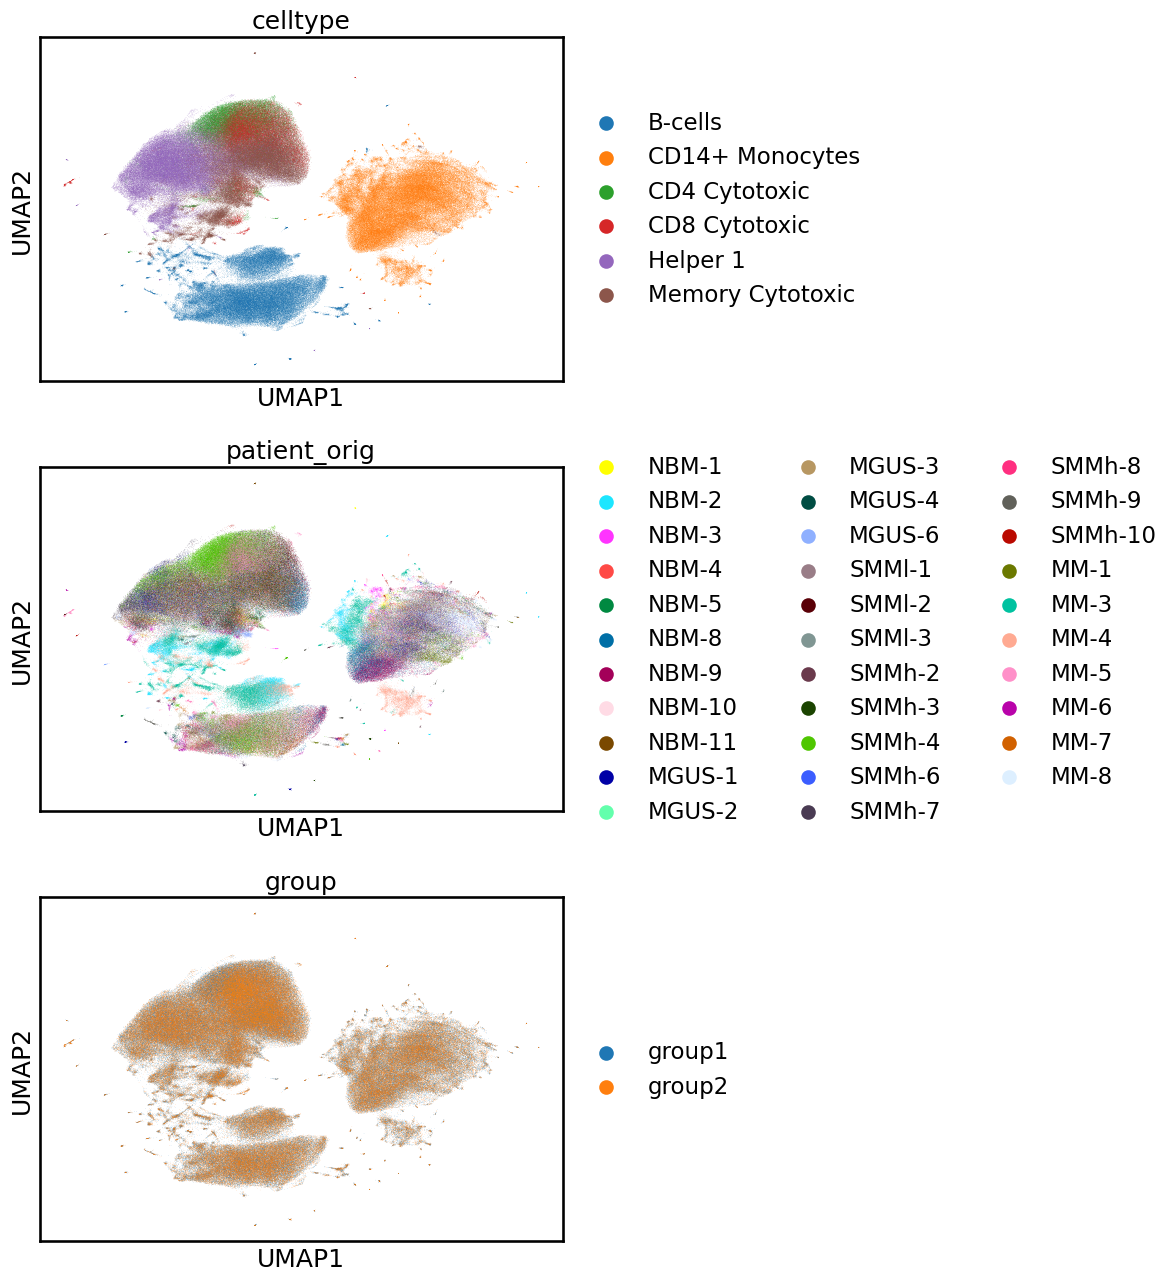

In [21]:
sc.pl.umap(adata, color=["celltype","patient_orig","group"], ncols=1)

### create dataloader

In [25]:
emb_name = "X_scGPT"
input_size = adata.obsm[emb_name].shape[1]
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.patient).reset_index().groupby("patient").mean()
batch_size = 128

#define targets
labels, targets = np.unique(adata.obs[['patient','group']].drop_duplicates().group, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Neural Network

In [26]:
### train model

# Example input and target tensors
hidden_size = 30
output_size = 2  # Binary classification, so output size is 2

# Initialize the Lightning model
lr = 0.001
logger = pl.loggers.TensorBoardLogger('logs/', name="props_exp_scvi_tsubtypes_0.1vs0.05c_dirstr30_1000pts__scGPT_mean__lr{}_bs{}".format(lr,batch_size), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN(input_size, hidden_size, output_size, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=200, logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

# TO DO: Figure out how to save the model from the best epoch
# TO DO: tensorboard is saving epoch level info with steps on the x-axis. how to change to epochs on x axis?

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 15.4 K
1 | relu    | ReLU    | 0     
2 | fc2     | Linear  | 62    
3 | softmax | Softmax | 0     
------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 111.89it/s, v_num=2340, train_loss_step=0.693, train_acc_step=0.467]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.56it/s]
Epoch 1: 100%|█| 6/6 [00:00<00:00, 81.58it/s, v_num=2340, train_loss_step=0.692, train_acc_step=0.600, val_loss_step=0.693, val_acc_step=0.455, val_loss_epoch=0.693, val_acc_epoch=0.480, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 45.45it/s]
Epoch 2: 100%|█| 6/6 [00:00<00:00, 83.61it/s, v_num=2340, train_loss_step=0.694, train_acc_step=0.450, val_loss_step=0.695, val_acc_step=0.364, val_loss_epoch=0.693, val_

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|█| 6/6 [00:00<00:00, 17.44it/s, v_num=2340, train_loss_step=0.667, train_acc_step=0.567, val_loss_step=0.721, val_acc_step=0.409, val_loss_epoch=0.692, val_acc_epoch=0.487, tr


In [27]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.6730), 'train_loss_step': tensor(0.6670), 'train_acc': tensor(0.6043), 'train_acc_step': tensor(0.5667), 'val_loss': tensor(0.6921), 'val_loss_epoch': tensor(0.6921), 'val_acc': tensor(0.4867), 'val_acc_epoch': tensor(0.4867), 'train_loss_epoch': tensor(0.6730), 'train_acc_epoch': tensor(0.6043)}


### KNN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


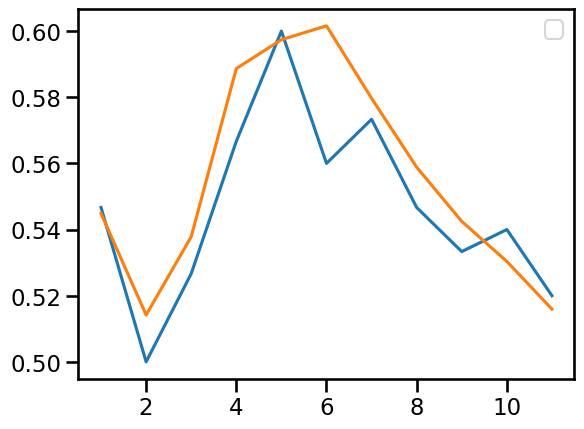

In [28]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)
plt.plot(Ks, val_aucs)
plt.legend()

In [29]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best K =  5
val acc:  0.6
val AUC:  0.597400284900285
test acc:  0.5266666666666666
test AUC:  0.5942235692636834


### logistic regression 

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

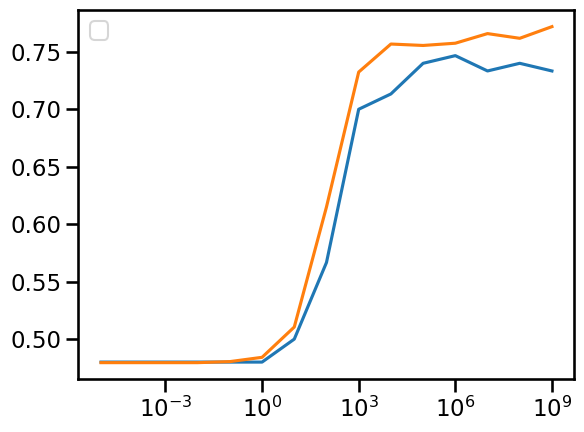

In [35]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8,1e9]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.legend()
plt.xscale("log")

In [36]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])

neigh = LogisticRegression(C=c)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best C =  1000000.0
val acc:  0.7466666666666667
val AUC  0.7574786324786325
test acc:  0.5266666666666666
test AUC:  0.8309859154929577


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### random forest

In [37]:
val_accs = []
val_aucs = []
Cs = [1,5,10,15,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)

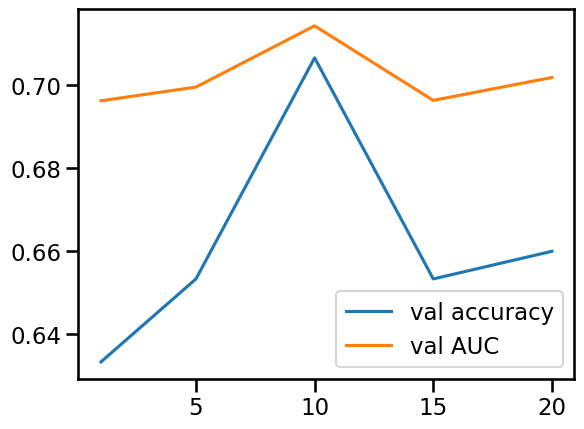

In [38]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [39]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best C =  10
test acc:  0.7066666666666667
test AUC  0.7143874643874644
test acc:  0.4533333333333333
test AUC:  0.731502941700838


## run baseline models using cell type proportions as input

### create dataloader

In [49]:
input_size = len(adata.obs.celltype.cat.categories)

## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby('patient').celltype.value_counts()).rename({'celltype':'cell_type_counts'},axis=1).reset_index().pivot(index="patient", columns="celltype", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df

#define targets
labels, targets = np.unique(adata.obs[['patient','group']].drop_duplicates().group, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(celltype_fracs_df)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


### Neural Network

In [45]:
### train model

# Example input and target tensors
hidden_size = 30
output_size = 2  # Binary classification, so output size is 2

# Initialize the Lightning model
lr = 0.001
logger = pl.loggers.TensorBoardLogger('logs/', name="props_exp_scvi_tsubtypes_0.1vs0.05c_dirstr30_1000pts__scGPT_mean__lr{}_bs{}".format(lr,batch_size), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN(input_size, hidden_size, output_size, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=200, logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

# TO DO: Figure out how to save the model from the best epoch
# TO DO: tensorboard is saving epoch level info with steps on the x-axis. how to change to epochs on x axis?

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 210   
1 | relu    | ReLU    | 0     
2 | fc2     | Linear  | 62    
3 | softmax | Softmax | 0     
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 87.76it/s, v_num=3437, train_loss_step=0.689, train_acc_step=0.517]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.53it/s]
Epoch 1: 100%|█| 6/6 [00:00<00:00, 79.53it/s, v_num=3437, train_loss_step=0.689, train_acc_step=0.617, val_loss_step=0.686, val_acc_step=0.591, val_loss_epoch=0.688, val_acc_epoch=0.580, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.58it/s]
Epoch 2: 100%|█| 6/6 [00:00<00:00, 79.19it/s, v_num=3437, train_loss_step=0.690, train_acc_step=0.633, val_loss_step=0.688, val_acc_step=0.636, val_loss_epoch=0.687, val_

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|█| 6/6 [00:00<00:00, 19.01it/s, v_num=3437, train_loss_step=0.600, train_acc_step=0.683, val_loss_step=0.651, val_acc_step=0.727, val_loss_epoch=0.515, val_acc_epoch=0.767, tr


In [46]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.4623), 'train_loss_step': tensor(0.5996), 'train_acc': tensor(0.7871), 'train_acc_step': tensor(0.6833), 'val_loss': tensor(0.5153), 'val_loss_epoch': tensor(0.5153), 'val_acc': tensor(0.7667), 'val_acc_epoch': tensor(0.7667), 'train_loss_epoch': tensor(0.4623), 'train_acc_epoch': tensor(0.7871)}


### KNN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


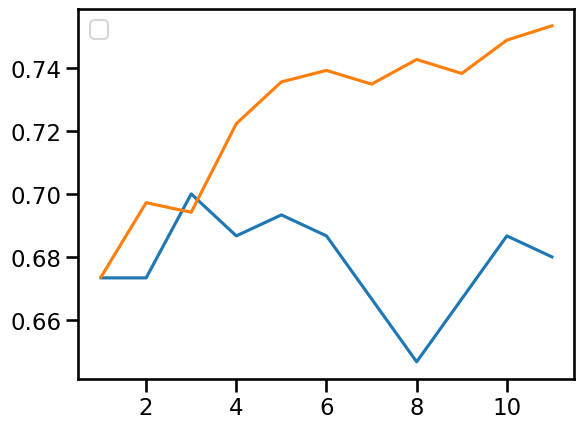

In [50]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)
plt.plot(Ks, val_aucs)
plt.legend()

In [51]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best K =  3
val acc:  0.7
val AUC:  0.6941773504273505
test acc:  0.4866666666666667
test AUC:  0.7522731324656802


### logistic regression 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


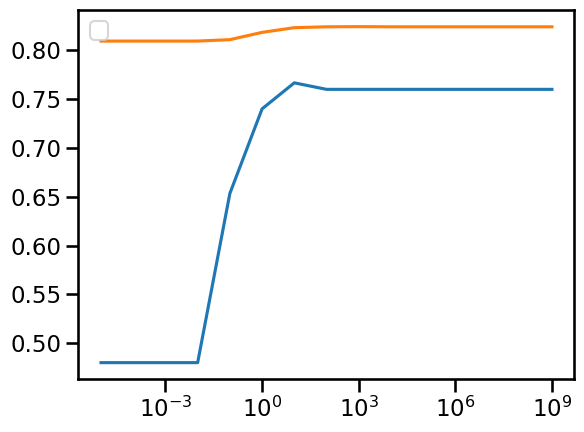

In [52]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8,1e9]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.legend()
plt.xscale("log")

In [53]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])

neigh = LogisticRegression(C=c)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best C =  10.0
val acc:  0.7666666666666667
val AUC  0.8231837606837606
test acc:  0.5133333333333333
test AUC:  0.8953467641290782


### random forest

In [54]:
val_accs = []
val_aucs = []
Cs = [1,5,10,15,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_acc = accuracy_score(targets[val_data.indices], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(targets[val_data.indices], neigh.predict_proba(pseudobulk_input.iloc[val_data.indices,:])[:,1])
    val_aucs.append(val_auc)

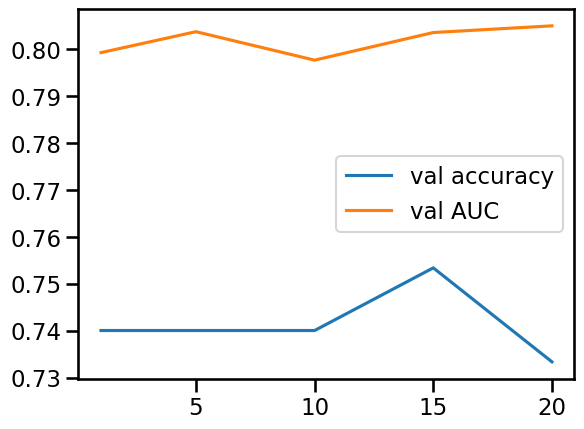

In [55]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [56]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test acc: ", accuracy_score(targets[test_data.indices], preds))
print("test AUC: ", roc_auc_score(targets[test_data.indices], neigh.predict_proba(pseudobulk_input.iloc[test_data.indices,:])[:,1]))

best C =  15
test acc:  0.7533333333333333
test AUC  0.8034188034188035
test acc:  0.5133333333333333
test AUC:  0.8596897842752719
